In [16]:
import os
import sys
import keras
import keras.backend as K
from keras import metrics
from numpy.lib.arraysetops import unique
import gdown
import numpy as np
import tempfile
import copy
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x = np.array(data['data']).transpose((0,2,3,1))
    y = np.array(data['label'])
    return x, y

In [18]:
#Data Loading
clean_x_test, clean_y_test = data_loader('/content/drive/MyDrive/lab3/valid.h5')
bad_x_test, bad_y_test = data_loader('/content/drive/MyDrive/lab3/bd_valid.h5')
bd_test, bd_test_l = data_loader('/content/drive/MyDrive/lab3/bd_test.h5')
test, test_l = data_loader('/content/drive/MyDrive/lab3/test.h5')

bad_model = keras.models.load_model('/content/drive/MyDrive/lab3/bd_net.h5')

In [19]:
ori_clean_acc = 0
def evaluation(model, clean_x_test, clean_y_test, bad_x_test, bad_y_test):
    clean_label_p = np.argmax(model.predict(clean_x_test),axis=1)
    ori_clean_acc = np.mean(np.equal(clean_label_p, clean_y_test))*100
    print('Original Clean accuracy:', ori_clean_acc)
    
    bad_label_p = np.argmax(model.predict(bad_x_test),axis=1)
    asr = np.mean(np.equal(bad_label_p, bad_y_test))*100
    print('Attack Success Rate:', asr)
    return ori_clean_acc

In [20]:
ori_clean_acc = evaluation(bad_model, clean_x_test, clean_y_test, bad_x_test, bad_y_test)
print(bad_model.summary())

Original Clean accuracy: 98.64899974019225
Attack Success Rate: 100.0
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                      

In [21]:
# Prunning
bad_model_copied = keras.models.clone_model(bad_model)
bad_model_copied.load_weights('/content/drive/MyDrive/lab3/bd_weights.h5') 

In [22]:
output=bad_model_copied.layers[6].output
prediction=keras.models.Model(inputs=bad_model_copied.input,outputs=output).predict(clean_x_test)  
channels = np.argsort(np.mean(prediction,axis=(0,1,2)))
temp_acc = []
asr_rate = []
flag2 = 1
flag4 = 1
flag10 = 1
zeroWeight = bad_model_copied.layers[5].get_weights()[0]
zeroBias = bad_model_copied.layers[5].get_weights()[1]

for i in channels:
  zeroWeight[:,:,:,i] = 0
  zeroBias[i] = 0
  bad_model_copied.layers[5].set_weights([zeroWeight,zeroBias])
  temp_accuracy = np.mean(np.equal(np.argmax(bad_model_copied.predict(clean_x_test), axis=1), clean_y_test))*100
  asr = np.mean(np.equal(np.argmax(bad_model_copied.predict(bad_x_test), axis=1), bad_y_test))*100
  temp_acc.append(temp_accuracy)
  asr_rate.append(asr)
  print("channel ",i,": ","The accuracy: ",temp_accuracy,"  The atk_rate: ",asr)

  drop = ori_clean_acc - temp_accuracy
  if drop >= 2 and flag2:
    bad_model_copied.save('/content/drive/MyDrive/lab3/X2_model.h5')
    flag2 = 0
    print('X2_model saved')
  if drop >= 4 and flag4:
    bad_model_copied.save('/content/drive/MyDrive/lab3/X4_model.h5')
    flag4 = 0
    print('X4_model saved')
  if drop >= 10 and flag10:
    bad_model_copied.save('/content/drive/MyDrive/lab3/X10_model.h5')
    flag10 = 0
    print('X10_model saved')
  keras.backend.clear_session()

channel  0 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  26 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  27 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  30 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  31 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  33 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  34 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  36 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  37 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  38 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  25 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  39 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  41 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel  44 :  The accuracy:  98.64899974019225   The atk_rate:  100.0
channel

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


channel  16 :  The accuracy:  95.20221702606739   The atk_rate:  99.9913397419243
channel  56 :  The accuracy:  94.7172425738287   The atk_rate:  99.9913397419243
channel  46 :  The accuracy:  92.09318437689443   The atk_rate:  99.9913397419243
X4_model saved
channel  5 :  The accuracy:  91.49562656967177   The atk_rate:  99.9913397419243
channel  8 :  The accuracy:  91.01931237550879   The atk_rate:  99.98267948384861
channel  11 :  The accuracy:  89.17467740538669   The atk_rate:  80.73958603966398
channel  54 :  The accuracy:  84.43751623798389   The atk_rate:  77.015675067117
X10_model saved
channel  10 :  The accuracy:  76.48739932449988   The atk_rate:  35.71490430414826
channel  28 :  The accuracy:  54.8627349095003   The atk_rate:  6.954187234779596
channel  35 :  The accuracy:  27.08928726076037   The atk_rate:  0.4243526457088421
channel  18 :  The accuracy:  13.87373343725643   The atk_rate:  0.0
channel  4 :  The accuracy:  7.101411622066338   The atk_rate:  0.0
channel  7 

In [23]:
#Good Net
unique_y = set(clean_y_test)  
print(len(unique_y))

1283


In [24]:
X2_model = keras.models.load_model('/content/drive/MyDrive/lab3/X2_model.h5')
X4_model = keras.models.load_model('/content/drive/MyDrive/lab3/X4_model.h5')
X10_model = keras.models.load_model('/content/drive/MyDrive/lab3/X10_model.h5')
evaluation(X2_model,test,test_l,bd_test,bd_test_l)
evaluation(X4_model,test,test_l,bd_test,bd_test_l)
evaluation(X10_model,test,test_l,bd_test,bd_test_l)

Original Clean accuracy: 95.90023382696803
Attack Success Rate: 100.0
Original Clean accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376
Original Clean accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


84.54403741231489

In [25]:
class G(keras.Model):
  def __init__(self, bad_m, bad_pm):
      super(G,self).__init__()
      self.bad_m = bad_m
      self.bad_pm = bad_pm

  def predict(self,inputX):
      bad_m_y = np.argmax(self.bad_m.predict(inputX), axis=1)
      bad_pm_y = np.argmax(self.bad_pm.predict(inputX), axis=1)
      y = np.zeros(len(bad_m_y))
      for i in range(len(bad_m_y)):
        if bad_m_y[i] != bad_pm_y[i]:
          y[i] = 1284  
        else:
          y[i] = bad_m_y[i]
      return y

In [26]:
#X=2%, 4%, 10% model evaluation
for model in [X2_model, X4_model, X10_model]:
  model = G(bad_model, model)
  clean_label_p = model.predict(clean_x_test)
  clean_accuracy = np.mean(np.equal(clean_label_p, clean_y_test))*100
  print('Clean Classification accuracy:', clean_accuracy)
  
  bad_label_p = model.predict(bad_x_test)
  asr = np.mean(np.equal(bad_label_p, bad_y_test))*100
  print('Attack Success Rate:', asr)

Clean Classification accuracy: 95.61790941370053
Attack Success Rate: 100.0
Clean Classification accuracy: 91.85935740885078
Attack Success Rate: 99.9913397419243
Clean Classification accuracy: 84.24699056031871
Attack Success Rate: 77.015675067117


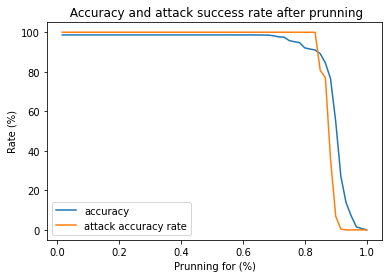

In [28]:
#plot
plt.title(" Accuracy and attack success rate after prunning")
plt.xlabel("Prunning for (%)")
plt.ylabel("Rate (%)")
plt.plot(x_axis,temp_acc,label="accuracy")
plt.plot(x_axis,asr_rate,label="attack accuracy rate")
plt.legend(loc="lower left")
plt.show()

Clean Classification accuracy: 95.61790941370053
X=2%, Attack Success Rate: 100.0

Clean Classification accuracy: 91.85935740885078
X=4%, Attack Success Rate: 99.9913397419243

Clean Classification accuracy: 84.24699056031871
X=10%, Attack Success Rate: 77.015675067117